# Demo of curve.py
## 1. Build curve

In [1]:
import curve
import instruments as inst
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
start_dates = [0, 0, 0, 0, 0]
end_dates = [1, 2, 3, 4, 5]
roll = 0.5
swap_rates = [0.01, 0.011, 0.012, 0.015, 0.016]
instruments = [inst.SingleCurrencySwap(start, end, roll)
    for start, end in zip(start_dates, end_dates)]


In [3]:
# generate curve grids same as swap end dates
grids = np.array(end_dates)
dfs = np.exp(-np.array(swap_rates) * grids)
linear = curve.Curve(grids, dfs, interpolation_method = 'log_linear')
cubic = curve.Curve(grids, dfs, interpolation_method = 'log_cubic')
mc = curve.Curve(grids, dfs, interpolation_method = 'monotone_convex')

In [4]:
built_linear = curve.build_curve(linear, instruments, swap_rates)
built_cubic = curve.build_curve(cubic, instruments, swap_rates)
built_mc = curve.build_curve(mc, instruments, swap_rates)

In [5]:
print('log linear :', [inst.par_rate(built_linear) for inst in instruments])
print('log cubic :', [inst.par_rate(built_cubic) for inst in instruments])
print('monotone convex :', [inst.par_rate(built_mc) for inst in instruments])

log linear : [0.010000016780143502, 0.01099987728347639, 0.011999761743478546, 0.015000196705425062, 0.01599979254956721]
log cubic : [0.009999920261503736, 0.011000028633552856, 0.011999891104977624, 0.015000037566396063, 0.016000058894971223]
monotone convex : [array([0.01000005]), array([0.01099993]), array([0.01199989]), array([0.01499989]), array([0.01600002])]


In [6]:
ts = np.arange(0, 5, 1. / 365)

### discount factor

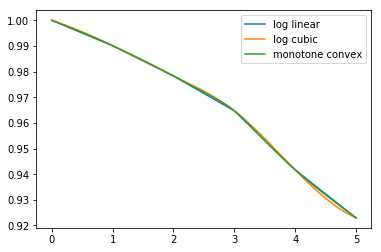

In [8]:
df_linear = built_linear.get_df(ts)
df_cubic = built_cubic.get_df(ts)
df_mc = built_mc.get_df(ts)
plt.plot(ts, df_linear, label = 'log linear')
plt.plot(ts, df_cubic, label = 'log cubic')
plt.plot(ts, df_mc, label = 'monotone convex')
plt.legend()
plt.show()

### forward curve

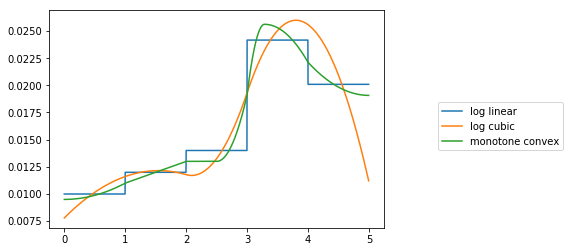

In [9]:
fwd_linear = -np.log(df_linear[1:] / df_linear[:-1]) / (ts[1:] - ts[:-1])
fwd_cubic = -np.log(df_cubic[1:] / df_cubic[:-1]) / (ts[1:] - ts[:-1])
fwd_mc = -np.log(df_mc[1:] / df_mc[:-1]) / (ts[1:] - ts[:-1])
plt.plot(ts[:-1], fwd_linear, label = 'log linear')
plt.plot(ts[:-1], fwd_cubic, label = 'log cubic')
plt.plot(ts[:-1], fwd_mc, label = 'monotone convex')
plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
plt.show()

## 2. Basis curve
### 2.1 Base curve

In [10]:
#base_grids = np.array([0.5, 1, 1.5, 2, 2.5])
#base_rates = np.array([0.005, 0.004, 0.006, 0.008, 0.01])

#base_dfs = np.exp(-np.array(base_rates) * base_grids)
#base_curve = curve.Curve(base_grids, base_dfs)
base_curve = built_linear

### 2.2 Basis curve

In [11]:
basis_grids = np.array([1, 2, 3, 4, 5])
basis_rates = np.array([0.00, 0.001, 0.001, 0.002, 0.003])
basis_dfs = np.exp(-np.array(basis_rates) * basis_grids)
print('basis_df :',basis_dfs)
basis_curve = curve.Curve(basis_grids, basis_dfs, 'monotone_convex')

composite_curve = curve.BasisCurve(base_curve, basis_curve)

basis_df : [1.         0.998002   0.9970045  0.99203191 0.98511194]


### discount factor

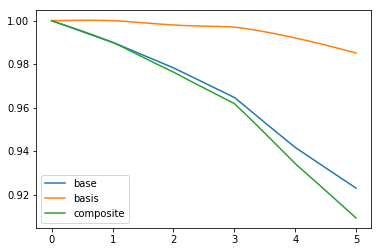

In [12]:
ts = np.arange(0, 5, 1/365)
df_base = base_curve.get_df(ts)
df_basis = basis_curve.get_df(ts)
df_composite = composite_curve.get_df(ts)
plt.plot(ts, df_base, label = 'base')
plt.plot(ts, df_basis, label = 'basis')
plt.plot(ts, df_composite, label = 'composite')
plt.legend()
plt.show()

### forward curve

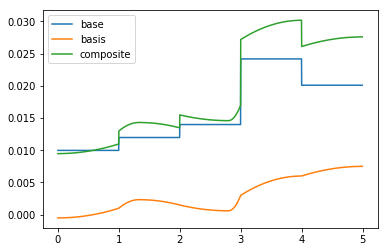

In [13]:
fwd_base = -np.log(df_base[1:] / df_base[:-1]) / (ts[1:] - ts[:-1])
fwd_basis = -np.log(df_basis[1:] / df_basis[:-1]) / (ts[1:] - ts[:-1])
fwd_composite = -np.log(df_composite[1:] / df_composite[:-1]) / (ts[1:] - ts[:-1])
plt.plot(ts[:-1], fwd_base, label = 'base')
plt.plot(ts[:-1], fwd_basis, label = 'basis')
plt.plot(ts[:-1], fwd_composite, label = 'composite')
plt.legend()
plt.show()


## 3. Turn curve

In [27]:
turn1_from = 0.25
turn1_to = 0.3
turn1_size = 0.005
turn1_curve = curve.TurnCurve(turn1_from, turn1_to, turn1_size)

In [28]:
turn2_from = 0.7
turn2_to = 0.75
turn2_size = 0.003
turn2_curve = curve.TurnCurve(turn2_from, turn2_to, turn2_size)

In [29]:
turned_curve = curve.BasisCurve(composite_curve, turn1_curve)
turned_curve = curve.BasisCurve(turned_curve, turn2_curve)

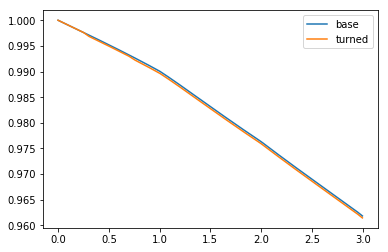

In [30]:
ts = np.arange(0, 3, 1/365)
df_base = composite_curve.get_df(ts)
df_turned = turned_curve.get_df(ts)
plt.plot(ts, df_base, label = 'base')
plt.plot(ts, df_turned, label = 'turned')
plt.legend()
plt.show()

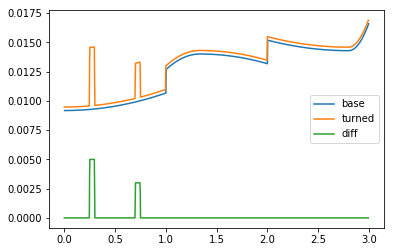

In [31]:
fwd_base = -np.log(df_base[1:] / df_base[:-1]) / (ts[1:] - ts[:-1])
fwd_turned = -np.log(df_turned[1:] / df_turned[:-1]) / (ts[1:] - ts[:-1])
# slide base curve for ease of look
plt.plot(ts[:-1] + 0.003 , fwd_base - 0.0003, label = 'base')
plt.plot(ts[:-1], fwd_turned, label = 'turned')
plt.plot(ts[:-1], fwd_turned - fwd_base, label = 'diff')
plt.legend()
plt.show()